In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   

Author: Andrew Tarzia

Date Created: 12 Feb 2018

License:

# Notebook for screening FASTA sequence files for their pI

TODO:
- input parameters
    - directory setup
    - pI cut-off
        - choose a value (6 implies no grey area)
    - modifications
- FASTA reader function
    - Ideally the biopython function should handle this but BRENDA fasta files do not have the proper formatting (they lack the ">" at the start of each object)
    - read input data and meta data
- screening function
    - test all modifications iff initial pI is not less then cut-off
        - get another method for calculating exposure without structure?
- modifications
    - introduce exposure consideration
    - generalise code to multiple target residues ("targ = convert_to_one_letter_code_sing('target_res')" needs to act on a list
- output to one CSV file
- timing information on small dataset
    - per sequence as a function of length
    - per sequence as a function of number of ionisable residues

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import time
import numpy as np

# Notes:
## Biopython:
- pK values and the methos are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


## modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [3]:
# input parameters
database_directory = '/home/atarzia/psp/sequence_db/test_dataset/'
dssp_dir = '/home/atarzia/zif-8/protein_specific_model/software/dssp/dssp-2.2.1/mkdssp'
# input FASTA file names
database_names = ['6_6_1_2__BRENDA_sequences.fasta']

# output CSV file
redo = True
out_CSV = "output_data.csv"
out_columns = ['fasta_file', 'acc.code', 'organism', 'EC.code', 'species', 
               'note', 'pi', 'modification', 'category']
if redo is True:
    string = ''
    for i in out_columns:
        string += i+','
    string += '\n'
    with open(out_CSV, 'w') as f:
        f.write(string)        

# cut off for ZIF growth from pI
cutoff_pi = 6

# modification types + colours
# just implement succinylation for now
# why would you want to do acetylation if you can succinylate??
# currently succinylation == LYS swapped with GLU
modifications = {
    '0': {
        'colour': 'k',
        'name': 'unmodified',
         },
    '1': {
        'colour': 'firebrick',
        'name': 'succinylated',
        'target_res': 'LYS',
        'replace_res': 'GLU',
         }
                }

In [4]:
os.chdir(database_directory)

In [5]:
# need to fix the FASTA output format so BIOPYTHON can read it
# for each FASTA file
for file in database_names:
    file_mod = file.replace(".fasta", "_mod.fasta")
    with open(file, 'r') as f:
        lines = f.readlines()
    new_lines = []
    for line in lines:
        if '|' in line and ">" not in line:
            # we replace spaces in header line with "__" 
            # so I can manipulate that later as biopython does not like "__"
            new_line = ">"+line.replace(" ","__")
            new_lines.append(new_line)
        else:
            new_lines.append(line)
    with open(file_mod, 'w') as f:
        for line in new_lines:
            f.write(line)

In [6]:
def convert_to_one_letter_code_sing(seq):
    conversion = {"GLY":"G","PRO":"P","VAL":"V","ALA":"A","LEU":"L",
                  "ILE":"I","MET":"M","CYS":"C","PHE":"F","TYR":"Y",
                  "TRP":"W","HIS":"H","ARG":"R","LYS":"K","GLN":"Q",
                  "THR":"T","ASP":"D","ASN":"N","SER":"S","GLU":"E"}
    n_seq = conversion[seq]
    return n_seq

In [7]:
count_sequences_done = 0
# for each FASTA file
for file in database_names:
    total_start_time = time.time()
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    file_mod = file.replace(".fasta", "_mod.fasta")
    with open(file_mod, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            start_time = time.time()
            record_list = record.id.split("|")
            # get meta data
            acc_code = record_list[0]
            organism = record_list[1]
            EC_code = record_list[2].replace("__"," ")
            species = record_list[3].replace("__"," ")
            note = record_list[4]
            # get unmodified pI
            seq = record.seq
            seq_obj = ProteinAnalysis(''.join(seq))
            pi = seq_obj.isoelectric_point()
            count_sequences_done += 1
            modifier = '0'
            if pi < cutoff_pi:
                category = '0'
            else:
                category = '1'
            # output to CSV
            with open(out_CSV, 'a') as f:
                string = file+','
                string += acc_code+','
                string += organism+','
                string += EC_code+','
                string += species+','
                string += note+','
                string += '{0:.2f}'.format(pi)+','
                string += modifier+','
                string += category+',\n'
                f.write(string)
            
            # if the category is 1 - i.e. pi > cutoff
            # then we test modification - else we do not
            if category == '1':
                modifier = '1'
                # get modified pI
                seq = record.seq
                # replace target amino acid residue
                # with replacement amino acid residue
                # one letter codes
                targ = convert_to_one_letter_code_sing(modifications[modifier]['target_res'])
                replacement = convert_to_one_letter_code_sing(modifications[modifier]['replace_res'])
                mod_seq = ''.join(seq).replace(targ, replacement)
                seq_obj = ProteinAnalysis(mod_seq)
                pi = seq_obj.isoelectric_point()
                count_sequences_done += 1
                if pi < cutoff_pi:
                    category = '0'
                else:
                    category = '1'
                # output to CSV
                with open(out_CSV, 'a') as f:
                    string = file+','
                    string += acc_code+','
                    string += organism+','
                    string += EC_code+','
                    string += species+','
                    string += note+','
                    string += '{0:.2f}'.format(pi)+','
                    string += modifier+','
                    string += category+',\n'
                    f.write(string)
            #break
    print('--- finished %s sequences in %s seconds ---' % (count_sequences_done, '{0:.2f}'.format(time.time() - total_start_time)))

--- finished 2771 sequences in 1.66 seconds ---


## plot all pIs in output CSV
### colour by modification


In [8]:
pi_data = pd.read_csv(out_CSV)

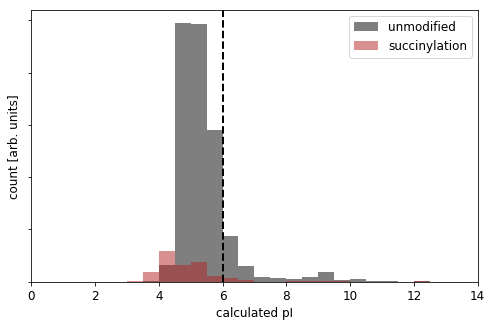

In [9]:
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize=(8, 5))
# unmodifed
mod_dict = modifications['0']
data = pi_data[pi_data['modification'] == 0]
n, bins, patches = ax.hist(data['pi'], facecolor=mod_dict['colour'], alpha = 0.5, 
                           bins=np.arange(0, 14 + 0.2, 0.5),
                           label = mod_dict['name'])

# modification 1 - succinylation
mod_dict = modifications['1']
data = pi_data[pi_data['modification'] == 1]
n, bins, patches = ax.hist(data['pi'], facecolor=mod_dict['colour'], alpha = 0.5, 
                           bins=np.arange(0, 14 + 0.2, 0.5),
                          label = mod_dict['name'])

ax.set_xlabel('calculated pI')
ax.set_ylabel('count [arb. units]')
ax.set_yticklabels([])

#plot cut-off
ax.axvline(x=cutoff_pi, c='k', lw='2', linestyle='--')

ax.set_xlim(0, 14)
ax.legend()


fig.savefig('pI_histogram.pdf', dpi=300, bbox_inches='tight')

### Code from pI_calc.py from prot_in_mof project

In [ ]:
import functions
import area_functions
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt

home_dir = '/home/atarzia/zif-8/protein_specific_model/'
scripts_dir = home_dir+'scripts/protein_mof_model/'
working_dir = home_dir+'working_dirs/'
metrics_dir = working_dir+'metrics_dir/'
production_data_dir = working_dir+'production_data/'
software_dir = '/home/atarzia/zif-8/protein_specific_model/software/'
pdb2pqr_loc = software_dir+'pdb2pqr/pdb2pqr.py'

# functions and constants
# pka and corresponding charge of amino acids and terminus'
# pKas are taken from PROPKA 3.0 model pKas. Assuming CYS are not forming
# disulphide bridges.
pKa = {'ASP': 3.8, 'GLU': 4.5,
       'HIS': 6.5, 'CYS': 9.0,
       'TYR': 10.0, 'LYS': 10.5,
       'ARG': 12.5, 'N-term': 8, 'C-term': 3.1}
charges = {'ASP': -1, 'GLU': -1,
           'HIS': 1, 'CYS': -1,
           'TYR': -1, 'LYS': 1,
           'ARG': 1, 'N-term': 1, 'C-term': -1}


def calculateAminoAcidCharge(amino_acid, pH, pKa):
    ratio = 1 / (1 + 10**(pH - pKa))

    if charges[amino_acid] == 1:
        return ratio
    else:
        return ratio - 1


def calculateProteinCharge(sequence, pH):
    protein_charge = calculateAminoAcidCharge('N-term', pH, pKa['N-term'])
    protein_charge += calculateAminoAcidCharge('C-term', pH, pKa['C-term'])

    for amino_acid in pKa.keys():
        pka = pKa[amino_acid]
        protein_charge += sequence.count(amino_acid) * calculateAminoAcidCharge(amino_acid, pH, pka)

    return protein_charge


def calculateProteinCharge_mod1(sequence, pH, target_residues, relative_areas):
    protein_charge = calculateAminoAcidCharge('N-term', pH, pKa['N-term'])
    protein_charge += calculateAminoAcidCharge('C-term', pH, pKa['C-term'])

    count_dict = {}
    for amino_acid in pKa.keys():
        count_dict[amino_acid] = 0

    for i, amino_acid in enumerate(sequence):
        if amino_acid in pKa.keys():
            if amino_acid in target_residues:
                if relative_areas[i] > 0.05:
                    # modification 1, therefore assume pka of LYS instead of
                    # GLU or ASP and opposing charge
                    pka = pKa['LYS']
                    amino_acid = 'LYS'
                    # add to count
                    count_dict[amino_acid] += 1
                else:
                    count_dict[amino_acid] += 1
            else:
                count_dict[amino_acid] += 1

    # add up protein charge
    for amino_acid in pKa.keys():
        pka = pKa[amino_acid]
        protein_charge += count_dict[amino_acid] * calculateAminoAcidCharge(amino_acid, pH, pka)

    return protein_charge


def calculateProteinCharge_mod2(sequence, pH, target_residues, relative_areas):
    protein_charge = calculateAminoAcidCharge('N-term', pH, pKa['N-term'])
    protein_charge += calculateAminoAcidCharge('C-term', pH, pKa['C-term'])

    count_dict = {}
    for amino_acid in pKa.keys():
        count_dict[amino_acid] = 0

    for i, amino_acid in enumerate(sequence):
        if amino_acid in pKa.keys():
            # modification 2:
            # therefore assume neutral instead of positive charge
            # so do not add to count
            if amino_acid not in target_residues:
                # count
                count_dict[amino_acid] += 1
            elif amino_acid in target_residues and relative_areas[i] <= 0.05:
                # implies unexposed target residue - count
                count_dict[amino_acid] += 1

    # add up protein charge
    for amino_acid in pKa.keys():
        pka = pKa[amino_acid]
        protein_charge += count_dict[amino_acid] * calculateAminoAcidCharge(amino_acid, pH, pka)

    return protein_charge


def calculateProteinCharge_mod3(sequence, pH, target_residues, relative_areas):
    protein_charge = calculateAminoAcidCharge('N-term', pH, pKa['N-term'])
    protein_charge += calculateAminoAcidCharge('C-term', pH, pKa['C-term'])

    count_dict = {}
    for amino_acid in pKa.keys():
        count_dict[amino_acid] = 0

    for i, amino_acid in enumerate(sequence):
        if amino_acid in pKa.keys():
            if amino_acid in target_residues:
                if relative_areas[i] > 0.05:
                    # modification 3, therefore assume pka of GLU instead of
                    # LYS and opposing charge
                    pka = pKa['GLU']
                    amino_acid = 'GLU'
                    # add to count
                    count_dict[amino_acid] += 1
                else:
                    count_dict[amino_acid] += 1
            else:
                count_dict[amino_acid] += 1

    # add up protein charge
    for amino_acid in pKa.keys():
        pka = pKa[amino_acid]
        protein_charge += count_dict[amino_acid] * calculateAminoAcidCharge(amino_acid, pH, pka)

    return protein_charge


def calculateIsoelectricPoint(sequence):
    min_pH, max_pH = float(0), float(14)

    while True:
        mid_pH = 0.5 * (max_pH + min_pH)
        protein_charge = calculateProteinCharge(sequence, mid_pH)

        if mid_pH > 13.8:
            return 14
        if mid_pH < 0.2:
            return 0
        if protein_charge > 0.1:
            min_pH = mid_pH
        elif protein_charge < -0.1:
            max_pH = mid_pH

        else:
            return mid_pH


def calculateIsoelectricPoint_mod(sequence, modification, target_residues,
                                  relative_areas):
    min_pH, max_pH = 0, 14

    while True:
        mid_pH = 0.5 * (max_pH + min_pH)
        if modification == 0:
            protein_charge = calculateProteinCharge(sequence, mid_pH)
        if modification == 1:
            protein_charge = calculateProteinCharge_mod1(sequence, mid_pH,
                                                         target_residues,
                                                         relative_areas)
        if modification == 2:
            protein_charge = calculateProteinCharge_mod2(sequence, mid_pH,
                                                         target_residues,
                                                         relative_areas)
        if modification == 3:
            protein_charge = calculateProteinCharge_mod3(sequence, mid_pH,
                                                         target_residues,
                                                         relative_areas)
        if mid_pH > 13.8:
            return 14
        if mid_pH < 0.2:
            return 0
        if protein_charge > 0.1:
            min_pH = mid_pH
        elif protein_charge < -0.1:
            max_pH = mid_pH

        else:
            return mid_pH


def run_pdb2pqr_toget_propka(pdb2pqrloc, pdb):
    """Run pdb1pqr to obtain propka output for a pdb file using the AMBER FF.

    """
    protein = pdb.replace(".pdb", '')
    pqr = protein+"_propka.pqr"
    # only run if apbs_in file does not exist
    # Example command line input
    # python2 /home/atarzia/zif-8/protein_specific_model/scripts/
    # protein_mof_model/software/pdb2pqr/pdb2pqr.py --apbs-input
    # --ph-calc-method=propka  --with-ph=1.0 --drop-water
    # --ff=parse myo.pdb myo_10.pqr
    cmd = 'python2 '+pdb2pqrloc
    cmd += ' --ph-calc-method=propka --with-ph=7 --drop-water --ff=amber '
    cmd += pdb+' '+pqr
    os.system(cmd)
    return pqr


def extract_pi_from_propka(propka_file):
    """Extract folded pI from bottom of PROPKA file.

    """

    if os.path.isfile(propka_file) is True:
        # collect ph, and charges from propka file

        with open(propka_file, 'r') as f:
            lines = f.readlines()
            important_lines = lines[-1]

        l = important_lines.rstrip().split(" ")
        l = list(filter(None, l))
        pi = l[3]

    return pi


def get_exposed_res(dssp, cutoff):
    """Collect list of exposed residues from DSSP calc.

    """
    # (dssp index, amino acid, secondary structure, relative ASA, phi, psi,
    # NH_O_1_relidx, NH_O_1_energy, O_NH_1_relidx, O_NH_1_energy,
    # NH_O_2_relidx, NH_O_2_energy, O_NH_2_relidx, O_NH_2_energy)

    # if relative ASA > 5% or 0.05
    # relative ASA = ASA / maximal ASA
    list_aa = functions.one_letter_codes()
    # output residue to exposed sequence
    exp_seq = []
    for r in list(dssp.keys()):
        aa_tup = dssp[r]
        if aa_tup[1] in list_aa:  # only want one of 20 amino acids
            if aa_tup[3] > cutoff:
                exp_seq.append(functions.convert_to_three_letter_code_sing(aa_tup[1]))
    return exp_seq


def reported_pis_errors():
    """ (pI, error) """
    db = {'myo': (10.5, 0.3), 'hrp': (6, 3), 'pepi': (2.86, 0),
          'haem': (0, 0), 'ure': (0, 0), 'haem2': (7.57, 0.55),
          "tryp": (10.7, 0), "lyzo": (0, 0), "lysozyme": (11, 0),
          'lip3': (6, 2), 'cat': (5.4, 0), 'cat2': (5.4, 0),
          'lip1': (6, 2), 'bsa': (5.28, 0), 'myo2': (10.5, 0.3),
          'lip4': (6, 2), 'ure2': (0, 0), 'ure3': (0, 0)}
    return db


print('=====================================================================')
print('Obtaining pI for all PDB files in: \n',
      metrics_dir)
print('=====================================================================')

print('protein,pI_full,pI_exposed,3D_pI,mod_1_pI,mod_2_pI,mod_3_pI')

os.chdir(metrics_dir)

proteins = []
reported = []
reported_error = []
errors = []
categories = []
pis = []
exposed_pis = []
pis_3d = []
# 0 = unmodfied
# 1 = amination
# 2 = acetylation
# 3 = succinylation
modification = []

for file in glob.glob("*.pdb"):
    if '_d' not in file and '_x' not in file:
        start_time = time.time()
        protein = file.replace(".pdb", "")
        # run on a pdb file as input
        pdb = protein+'.pdb'

        try:
            good_name = functions.name_db()[protein]
            category = functions.category()[protein]
        except KeyError:
            good_name = protein
            category = 'na'

        # reported values
        try:
            rep, pi_error = reported_pis_errors()[protein]
        except KeyError:
            rep, pi_error = 'na', 'na'

        # read Bio.PDB structure
        structure = functions.obtain_pdb_structure(protein, pdb)

        # get full sequence using Bio.PDB
        full_res = [r for r in structure.get_residues()]
        # only the amino acid residues
        full_sequence = [r.resname for r in full_res if r.get_id()[0] == ' ']

        # use DSSP (http://www.cmbi.ru.nl/dssp.html) to get ASA properties of
        # protein and amino acid and use a definition of 5% relative ASA to
        # distinguish between exposed and buried residues
        dssp_dir = software_dir+'dssp/dssp-2.2.1/mkdssp'
        dssp = area_functions.run_dssp(structure, pdb, dssp_dir)
        exposed_sequence = get_exposed_res(dssp, 0.05)
        # output % ASA of all residues to be used as input for modification
        # code. modifications only occur for residues with > 5% relative ASA
        dssp_res, dssp_res_area, dssp_rel_area, dssp_res_ids = area_functions.calculate_res_area_v2(dssp, area_functions.wilke_arr())

        # calculate full sequence and exposed sequence pI from
        # Henderson-Hasselbach Equation and model pKas
        target_amino_acid = []
        m = 0
        pI = calculateIsoelectricPoint(full_sequence)
        exposed_pI = calculateIsoelectricPoint(exposed_sequence)

        # obtain pI for the folded 3D structure calculated by PROPKA 3.0
        # run propka
        pqr_out = run_pdb2pqr_toget_propka(pdb2pqr_loc,
                                           pdb)
        # propka file
        propka_file = protein+"_propka.propka"
        # extact folded pI from PROPKA
        pI_3d = extract_pi_from_propka(propka_file)

        # only want data for experimentally tested proteins (i.e. they have
        # a category)
        if category != 'na':
            # append non modified data
            proteins.append(good_name)
            categories.append(category)
            reported.append(rep)
            reported_error.append(pi_error)
            pis.append(pI)
            exposed_pis.append(exposed_pI)
            pis_3d.append(float(pI_3d))
            # unmodified
            modification.append(0)
            # apply modifications
            # calculate pI of chemically modified protein with 100 % conversion
            # given target residues
            ##########################################################
            # amination (GLU and ASP to +ve)
            m = 1
            # get protein category for this modification
            try:
                mod_category = functions.mod_category()[protein+"_"+str(m)]
            except:
                mod_category = 'na'
            if mod_category != 'na':
                # target amino acid we only apply this on exposed residues!
                target_amino_acid = ['GLU', 'ASP']
                # get modified sequence
                mod_pI_1 = calculateIsoelectricPoint_mod(dssp_res, m,
                                                         target_amino_acid,
                                                         dssp_rel_area)
                # append modified data
                proteins.append(good_name)
                categories.append(mod_category)
                pis.append(mod_pI_1)  # this is the modified pI
                exposed_pis.append(0)
                pis_3d.append(0)
                reported.append(0)
                reported_error.append(0)
                modification.append(m)
            else:
                mod_pI_1 = 0
            ##########################################################
            # acetylation (LYS to neutral)
            m = 2
            # get protein category for this modification
            try:
                mod_category = functions.mod_category()[protein+"_"+str(m)]
            except:
                mod_category = 'na'
            if mod_category != 'na':
                # target amino acid we only apply this on exposed residues!
                target_amino_acid = ['LYS']
                # get modified sequence
                mod_pI_2 = calculateIsoelectricPoint_mod(dssp_res, m,
                                                         target_amino_acid,
                                                         dssp_rel_area)
                # append modified data
                proteins.append(good_name)
                categories.append(mod_category)
                pis.append(mod_pI_2)  # this is the modified pI
                exposed_pis.append(0)
                pis_3d.append(0)
                reported.append(0)
                reported_error.append(0)
                modification.append(m)
            else:
                mod_pI_2 = 0
            ##########################################################
            # succinylation (LYS to -ve)
            m = 3
            # get protein category for this modification
            try:
                mod_category = functions.mod_category()[protein+"_"+str(m)]
            except:
                mod_category = 'na'
            if mod_category != 'na':
                # target amino acid we only apply this on exposed residues!
                target_amino_acid = ['LYS']
                # get modified sequence
                mod_pI_3 = calculateIsoelectricPoint_mod(dssp_res, m,
                                                         target_amino_acid,
                                                         dssp_rel_area)
                # append modified data
                proteins.append(good_name)
                categories.append(mod_category)
                pis.append(mod_pI_3)  # this is the modified pI
                exposed_pis.append(0)
                pis_3d.append(0)
                reported.append(0)
                reported_error.append(0)
                modification.append(m)
            else:
                mod_pI_3 = 0
            ##########################################################
            print('----', good_name, ',',
                  '{0:.2f}'.format(pI), ',',
                  '{0:.2f}'.format(exposed_pI), ',',
                  pI_3d, ',',
                  '{0:.2f}'.format(mod_pI_1), ',',
                  '{0:.2f}'.format(mod_pI_2), ',',
                  '{0:.2f}'.format(mod_pI_3),
                  '----')

print('=====================================================================')
print('                              Complete!                              ')
print('=====================================================================')

print('=====================================================================')
print('                              Plotting!                              ')
print('=====================================================================')

os.chdir(production_data_dir)


def general_categ_plot(y_data, category_data, out_name, y_axis_name,
                       y_min, y_max, title):
    # collect number of yes and nos
    countn1 = 0
    county1 = 0
    for i in category_data:
        if i == 1:
            county1 += 1
        elif i == 0:
            countn1 += 1
    # set mid point, space between points for yes and no categ
    MPy = 0.25
    MPn = 0.75
    Sy = 0.04
    Sn = 0.04
    # set positions for y and n
    posy = [MPy - (county1/2 * Sy) + i * Sy for i in np.arange(county1)]
    posn = [MPn - (countn1/2 * Sn) + i * Sn for i in np.arange(countn1)]
    countn = 0
    county = 0
    fig, ax = plt.subplots(figsize=(5, 5))
    for i, cat in zip(y_data, category_data):
        # if the proteins seeds growth we plt as a different colour
        if cat == 1:
            # YES
            y = ax.scatter(posy[county], i,
                           c='b',
                           s=100)
            county += 1
        elif cat == 0:
            # no
            n = ax.scatter(posn[countn], i,
                           edgecolor='r',
                           facecolor='none',
                           s=100)
            countn += 1
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xticks([0.25, 0.75])
    ax.legend([y, n], ['ZIF', 'no ZIF'], loc=2, fancybox=True,
              fontsize=12)
    # Set ticks labels for x-axis
    ax.set_xticklabels(['ZIF', 'no ZIF'])
    ax.set_ylabel(y_axis_name, fontsize=12)
    ax.set_xlim(0, 1)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title, fontsize=12)
    fig.savefig(out_name, dpi=300, bbox_inches='tight')

# categorical plots of pIs
# 3D model
y_data, cat_data = [], []
for i, j in enumerate(proteins):
    # if the proteins seeds growth we plt as a different colour
    if categories[i] == 1 and modification[i] == 0:
        # YES
        y_data.append(pis_3d[i])
        cat_data.append(1)
    elif modification[i] == 0:
        # no
        y_data.append(pis_3d[i])
        cat_data.append(0)
out_name = "categ_pI_3D.pdf"
y_axis_name = 'calculated pI'
y_min, y_max = (1, 13)
title = '3D model'
general_categ_plot(y_data, cat_data, out_name, y_axis_name,
                   y_min, y_max, title)

# exposed sequence
y_data, cat_data = [], []
for i, j in enumerate(proteins):
    # if the proteins seeds growth we plt as a different colour
    if categories[i] == 1 and modification[i] == 0:
        # YES
        y_data.append(exposed_pis[i])
        cat_data.append(1)
    elif modification[i] == 0:
        # no
        y_data.append(exposed_pis[i])
        cat_data.append(0)
out_name = "categ_pI_exp_seq.pdf"
y_axis_name = 'calculated pI'
y_min, y_max = (1, 13)
title = 'exposed sequence'
general_categ_plot(y_data, cat_data, out_name, y_axis_name,
                   y_min, y_max, title)

# full sequence
y_data, cat_data = [], []
for i, j in enumerate(proteins):
    # if the proteins seeds growth we plt as a different colour
    if categories[i] == 1 and modification[i] == 0:
        # YES
        y_data.append(pis[i])
        cat_data.append(1)
    elif modification[i] == 0:
        # no
        y_data.append(pis[i])
        cat_data.append(0)
out_name = "categ_pI_full_seq.pdf"
y_axis_name = 'calculated pI'
y_min, y_max = (1, 13)
title = 'sequence model'
general_categ_plot(y_data, cat_data, out_name, y_axis_name,
                   y_min, y_max, title)

# parity plot of 3D and sequence pIs
# full sequence
fig, ax = plt.subplots(figsize=(5, 5))
for i, j in enumerate(proteins):
    # if the proteins seeds growth we plt as a different colour
    if categories[i] == 1 and modification[i] == 0:
        # YES
        y = ax.scatter(pis[i], pis_3d[i],
                       c='b', s=100)
    elif modification[i] == 0:
        # no
        n = ax.scatter(pis[i], pis_3d[i], edgecolor='r',
                       facecolor='none', s=100)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('sequence model pI', fontsize=12)
ax.set_ylabel('3D model pI', fontsize=12)
ax.legend([y, n], ['ZIF', 'no ZIF'], loc=2, fancybox=True, fontsize=12)
ax.set_xlim(1, 13)
ax.set_ylim(1, 13)
# plot y = x line
x = np.linspace(0, 14, 200)
ax.plot(x, x, c='k', alpha=0.5)
fig.savefig("full_sequence_pI_vs_3d_pI.pdf", dpi=300,
            bbox_inches='tight')

# exposed sequence
fig, ax = plt.subplots(figsize=(5, 5))
for i, j in enumerate(proteins):
    # if the proteins seeds growth we plt as a different colour
    if categories[i] == 1 and modification[i] == 0:
        # YES
        y = ax.scatter(exposed_pis[i], pis_3d[i],
                       c='b', s=100)
    elif modification[i] == 0:
        # no
        n = ax.scatter(exposed_pis[i], pis_3d[i], edgecolor='r',
                       facecolor='none', s=100)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('exposed sequence pI', fontsize=12)
ax.set_ylabel('3D model pI', fontsize=12)
ax.legend([y, n], ['ZIF', 'no ZIF'], loc=2, fancybox=True, fontsize=12)
ax.set_xlim(1, 13)
ax.set_ylim(1, 13)
# plot y = x line
x = np.linspace(0, 14, 200)
ax.plot(x, x, c='k', alpha=0.5)
fig.savefig("exposed_sequence_pI_vs_3d_pI.pdf", dpi=300,
            bbox_inches='tight')

# reported
fig, ax = plt.subplots(figsize=(5, 5))
for i, j in enumerate(proteins):
    # if the proteins seeds growth we plt as a different colour
    if categories[i] == 1 and modification[i] == 0:
        # YES
        y = ax.scatter(reported[i], pis_3d[i],
                       c='b', s=100)
        ax.errorbar(reported[i], pis_3d[i], xerr=reported_error[i],
                    c='b', alpha=0.8)
    elif modification[i] == 0:
        # no
        n = ax.scatter(reported[i], pis_3d[i], edgecolor='r',
                       facecolor='none', s=100)
        ax.errorbar(reported[i], pis_3d[i], xerr=reported_error[i],
                    c='r', alpha=0.8)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('reported pI', fontsize=12)
ax.set_ylabel('3D model pI', fontsize=12)
ax.legend([y, n], ['ZIF', 'no ZIF'], loc=2, fancybox=True, fontsize=12)
ax.set_xlim(1, 13)
ax.set_ylim(1, 13)
# plot y = x line
x = np.linspace(0, 14, 200)
ax.plot(x, x, c='k', alpha=0.5)
fig.savefig("reported_pI_vs_3d_pI.pdf", dpi=300,
            bbox_inches='tight')

# categorical plot of all pI data

# modified proteins
mod_p = ['bsa', 'pepi', 'myo', 'myo2', 'haem', 'haem2']
mod_good_name = [functions.name_db()[i] for i in mod_p]

y_data, cat_data, markers, colours = [], [], [], []
for i, j in enumerate(proteins):
    if j in mod_good_name:
        # if the proteins seeds growth we plt as a different colour
        if categories[i] == 1:
            # YES
            y_data.append(pis[i])
            cat_data.append(1)
            if modification[i] == 0:
                colours.append('k')
            elif modification[i] == 1:
                colours.append('steelblue')
            elif modification[i] == 2:
                colours.append('forestgreen')
            elif modification[i] == 3:
                colours.append('firebrick')
            if 'BSA' in proteins[i]:
                markers.append('.')
            elif 'Pepsin' in proteins[i]:
                markers.append('*')
            elif 'Haemoglobin' in proteins[i]:
                markers.append('+')
            elif 'Myoglobin' in proteins[i]:
                markers.append('x')
        else:
            # no
            y_data.append(pis[i])
            cat_data.append(0)
            if modification[i] == 0:
                colours.append('k')
            elif modification[i] == 1:
                colours.append('steelblue')
            elif modification[i] == 2:
                colours.append('forestgreen')
            elif modification[i] == 3:
                colours.append('firebrick')
            if 'BSA' in proteins[i]:
                markers.append('.')
            elif 'Pepsin' in proteins[i]:
                markers.append('*')
            elif 'Haemoglobin' in proteins[i]:
                markers.append('+')
            elif 'Myoglobin' in proteins[i]:
                markers.append('x')


# collect number of yes and nos
countn1 = 0
county1 = 0
for i in cat_data:
    if i == 1:
        county1 += 1
    elif i == 0:
        countn1 += 1
# set mid point, space between points for yes and no categ
MPy = 0.25
MPn = 0.75
Sy = 0.02
Sn = 0.02
# set positions for y and n
posy = [MPy - (county1/2 * Sy) + i * Sy for i in np.arange(county1)]
posn = [MPn - (countn1/2 * Sn) + i * Sn for i in np.arange(countn1)]
countn = 0
county = 0

fig, ax = plt.subplots(figsize=(5, 5))
pts = []
for i, y in enumerate(y_data):
    # if the proteins seeds growth we plt as a different colour
    if cat_data[i] == 1:
        # YES
        pts.append(ax.scatter(posy[county], y,
                              c=colours[i],
                              marker=markers[i],
                              s=200))
        county += 1
    elif cat_data[i] == 0:
        # no
        pts.append(ax.scatter(posn[countn], y,
                              c=colours[i],
                              marker=markers[i],
                              s=200))
        countn += 1

# Set number of ticks for x-axis
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks([0.25, 0.75])
#['no modification', 'acetylation', 'succinylation', 'amination'],
ax.legend([pts[0], pts[1], pts[5], pts[6], pts[7],
           pts[8], pts[9], pts[2], pts[3], pts[4]],
        ['BSA','aminated\nBSA', 'pepsin', 'aminated\npepsin', 'haemoglobin',
         'acetylated\nhaemoglobin', 'succinylated\nhaemoglobin',
         'myoglobin', 'acetylated\nmyoglobin', 'succinylated\nmyoglobin'],
          loc=2, frameon=False, bbox_to_anchor=(1.01, 1.01),
          fontsize=12)
# ax.legend(pts,
#          np.arange(len(pts)),
#          loc=2, fancybox=True,
#          fontsize=12)
# Set ticks labels for x-axis
ax.set_xticklabels(['protein@ZIF', 'no protein@ZIF'])
ax.set_ylabel("calculated pI", fontsize=12)
ax.set_xlim(0, 1)
ax.set_ylim(1, 12)
fig.savefig('pI_categorical_full.pdf', dpi=300,
            bbox_inches='tight')

print('=====================================================================')
print('                       Complete! Thank you!                          ')
print('=====================================================================')